# Welcome to the Traffic Sign Classification Project

**Project Overview**

This project is not just about building a simple classification model—it is about developing a robust and reliable system that can accurately recognize all traffic sign classes without bias. The goal is to create a model that performs well not only on the training data but also in real-world scenarios, where misclassification could have critical consequences.

Beyond achieving high accuracy, this work also focuses on systematic hyperparameter tuning, data preprocessing, and augmentation techniques to improve generalization, reduce overfitting, and ensure the model can confidently distinguish between similar signs.


**Business Statement**

To develop a robust, accurate, and efficient traffic sign recognition system that can be integrated into intelligent transportation solutions, enabling safer autonomous driving and reducing the risk of accidents caused by misclassification of traffic signs. This project aims to deliver a production-ready model that ensures compliance with traffic regulations, improves driver assistance systems, and enhances overall road safety.



In [1]:
## Importing the necessary libraries


import pandas as pd
import numpy as np
import glob
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import random
from PIL import Image
import cv2
import kagglehub
import warnings
warnings.filterwarnings('ignore')


In [2]:


# Downloading the dataset from kaggle

path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign


In [3]:


os.listdir(path)

['Meta',
 'meta',
 'Meta.csv',
 'Train.csv',
 'Test.csv',
 'Test',
 'test',
 'Train',
 'train']

The dataset contains separate folders for training and testing but does not include a dedicated validation set. Please note that having a validation set is very important for monitoring performance during training. Validation would be conned later on.

In [4]:
## path to the train data

train_dir = r'/kaggle/input/gtsrb-german-traffic-sign/Train'

In [5]:
# Path to the test data that contains CLASS ID for each photo

test_dir = r'/kaggle/input/gtsrb-german-traffic-sign/Test.csv'

In [6]:
# Loading the csv

test_df = pd.read_csv(test_dir)

In [7]:
test_df.head()

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png

In [8]:
## creating another test data with the relevant columns needed.

test_df = test_df[["Path", "ClassId"]]

In [10]:
## Renaming the columns to maintain consistence with my training set and validation set which would be conned later

test_df.rename(columns={"Path": "filepaths", "ClassId": "labels"}, inplace=True)

In [11]:
## The training directory has 43 subfolders for each class, which makes sense since there are 43 classes

os.listdir(train_dir)

['7',
 '17',
 '19',
 '22',
 '2',
 '35',
 '23',
 '10',
 '5',
 '36',
 '20',
 '27',
 '41',
 '39',
 '32',
 '25',
 '42',
 '8',
 '38',
 '12',
 '0',
 '31',
 '34',
 '18',
 '28',
 '16',
 '13',
 '26',
 '15',
 '3',
 '1',
 '30',
 '14',
 '4',
 '9',
 '21',
 '40',
 '6',
 '11',
 '37',
 '33',
 '29',
 '24']

In [12]:
len(os.listdir(train_dir))

43

In [13]:

train_filepaths = glob.glob('/kaggle/input/gtsrb-german-traffic-sign/Train/*/*.png')

labels = [os.path.basename(os.path.dirname(path)) for path in train_filepaths]

Iterating through all the images in the training directory and saving their file paths in a column called filepaths and their corresponding subfolder names as labels. This approach allows me to convert the directory structure into a DataFrame so I can easily manipulate the data and create an effective validation set from it.

array([[[58, 49, 45],
        [49, 43, 39],
        [43, 39, 35],
        ...,
        [35, 34, 37],
        [33, 32, 35],
        [31, 30, 34]],

       [[49, 42, 38],
        [44, 39, 36],
        [39, 36, 33],
        ...,
        [36, 34, 38],
        [31, 29, 33],
        [32, 30, 34]],

       [[47, 41, 38],
        [44, 40, 37],
        [41, 39, 36],
        ...,
        [37, 33, 33],
        [32, 29, 31],
        [34, 31, 35]],

       ...,

       [[39, 39, 39],
        [40, 40, 40],
        [37, 37, 38],
        ...,
        [32, 32, 32],
        [32, 32, 32],
        [31, 31, 32]],

       [[39, 39, 39],
        [41, 41, 41],
        [36, 36, 37],
        ...,
        [35, 34, 35],
        [33, 33, 34],
        [32, 32, 33]],

       [[39, 39, 39],
        [37, 37, 38],
        [35, 35, 35],
        ...,
        [31, 30, 33],
        [31, 30, 32],
        [31, 31, 32]]], dtype=uint8)
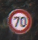

In [14]:
## Checking random images from the path and i discovered the images have 3 channels i.e 3 depth and shape isn't consistent among images

pic = Image.open(train_filepaths[random.randint(0,len(train_filepaths))])
pic.arr = np.asarray(pic)
pic.arr

In [16]:
## Converting to a dataframe now

train_df = pd.DataFrame({
    'filepaths': train_filepaths,
    'labels': labels
})


In [17]:
# Dataframe done successfully

train_df.head()

filepaths labels
0  /kaggle/input/gtsrb-german-traffic-sign/Train/...      7
1  /kaggle/input/gtsrb-german-traffic-sign/Train/...      7
2  /kaggle/input/gtsrb-german-traffic-sign/Train/...      7
3  /kaggle/input/gtsrb-german-traffic-sign/Train/...      7
4  /kaggle/input/gtsrb-german-traffic-sign/Train/...      7

Don't forget the dataset comes with separate training and test sets. To effectively track my model’s performance and reduce the risk of overfitting, I will split 15% of the training set into a validation set.

Although I could perform k-fold cross-validation on the entire training set for more robust evaluation, this approach would be too time-consuming given my limited computing resources. Therefore, creating a dedicated validation set is a more practical choice.

KEY NOTE: Having a validation set is essential—it allows me to properly tune hyperparameters, monitor the model’s learning process, and quickly identify when overfitting begins.










In [18]:
## Stratifying to ensure an even distribution of class labels across the splits and avoid class imbalance issues.

train_df, val_df = train_test_split(train_df,test_size=0.15,stratify=train_df["labels"],random_state=42,shuffle=True)

In [19]:
## validation set successfully with 5882 rows, notice that the labels are in object instead of integer. i will handle that later

val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5882 entries, 490 to 30754
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  5882 non-null   object
 1   labels     5882 non-null   object
dtypes: object(2)
memory usage: 137.9+ KB


In [20]:
## Just checking for any potential error

assert len(train_df['labels'].unique()) == 43, "Expected 43 classes, but found something different!"
assert len(val_df['labels'].unique()) == 43, "Expected 43 classes, but found something different!"
assert len(test_df['labels'].unique()) == 43, "Expected 43 classes, but found something different!"

In [21]:
## My training set has enough data for the training. Also noticed the labels in objects datatype, right?

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33327 entries, 17996 to 38605
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  33327 non-null  object
 1   labels     33327 non-null  object
dtypes: object(2)
memory usage: 781.1+ KB


In [24]:

print(train_df['labels'].value_counts())


labels
2     1912
1     1887
13    1836
12    1785
38    1759
10    1708
4     1683
5     1581
25    1275
9     1249
7     1224
8     1198
3     1198
11    1122
35    1020
18    1020
17     943
14     663
31     663
33     586
15     535
26     510
28     459
23     433
30     382
34     357
16     357
6      357
22     332
36     332
40     306
20     306
21     281
39     255
29     230
24     230
32     204
42     204
41     204
27     204
19     179
0      179
37     179
Name: count, dtype: int64


The training set is always a priority when it comes to building a robust model. A quick check of the class labels indicates that some classes are underrepresented. It’s important to ensure balanced classes during data collection, as this leads to more reliable training outcomes and better performance. However, I will visualize the distribution later to better understand what is happening and analyize possible solution to this

In [25]:
## mapping the labels to get better understanding what they represent.

class_titles = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing veh over 3.5 tons',
    11: 'Right-of-way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End speed + passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End no passing veh > 3.5 tons'
}


In [26]:
## Creating another column called title in both the training and test DataFrames for clarity. This step is optional but can help make the data easier to interpret.

train_df['title'] = train_df['labels'].map(class_titles)
test_df["title"] = test_df["labels"].map(class_titles)


In [27]:
train_df.head()

filepaths  labels  \
17996  /kaggle/input/gtsrb-german-traffic-sign/Train/...      12   
38086  /kaggle/input/gtsrb-german-traffic-sign/Train/...      33   
12725  /kaggle/input/gtsrb-german-traffic-sign/Train/...      32   
16710  /kaggle/input/gtsrb-german-traffic-sign/Train/...      38   
19076  /kaggle/input/gtsrb-german-traffic-sign/Train/...      12   

                            title  
17996               Priority road  
38086            Turn right ahead  
12725  End speed + passing limits  
16710                  Keep right  
19076               Priority road

In [28]:

test_df.head()

filepaths  labels                         title
0  Test/00000.png      16     Veh > 3.5 tons prohibited
1  Test/00001.png       1          Speed limit (30km/h)
2  Test/00002.png      38                    Keep right
3  Test/00003.png      33              Turn right ahead
4  Test/00004.png      11  Right-of-way at intersection

Notice that the filepaths column in test_df points to a subfolder named Test. This means I need to join the root directory path with these filenames to correctly locate and load the images.

In [30]:
## Visualizing random examples from all class labels.

##  Picking a random image per class
samples = []
for label in sorted(train_df['labels'].unique()):
    df_class = train_df[train_df['labels'] == label]
    random_row = df_class.sample(n=1, random_state=random.randint(0, len(train_df)))
    samples.append(random_row)

samples_df = pd.concat(samples).reset_index(drop=True)

## Creating subplots  to display every image per class
fig, axes = plt.subplots(nrows=5, ncols=9, figsize=(20, 12))
axes = axes.flatten()

## Ploting each image with the title
for idx, (ax, (_, row)) in enumerate(zip(axes, samples_df.iterrows())):
    img = Image.open(row['filepaths'])
    ax.imshow(img)
    ax.set_title(f"{row['labels']}: {row['title']}", fontsize=8)
    ax.axis('off')

##  Hiding empty subplots because i am expected to get 9 images at the 5 row
for i in range(len(samples_df), len(axes)):
    axes[i].axis('off')

##  Showing my images
plt.tight_layout()
plt.show()


## Keep in mind that rerunning the code will display different photos for each class, because the random seed depends on the length of the training dataset.

In [31]:
## Now, i'm visualizing the labels

train_df['title'].value_counts().sort_index().plot(kind='bar', figsize=(12,4))
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Number of Images per Class")
plt.show()

Now it is evident that some classes are underrepresented. What will I do next? well, I will first work with the data as it is to observe the model’s performance and generalization. Afterwards, I will apply augmentation techniques and compare how the performance and generalization improve.

## Proprocessing my train images

Random index: 1
Image Shape: (42, 41, 3)


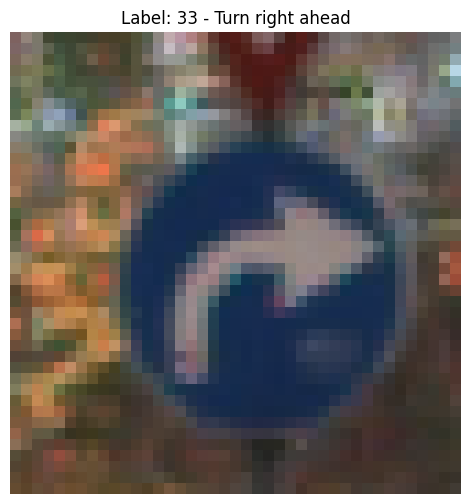

In [32]:
## Visualizing random image to see how it looks before preprocessing

##  Picking a random image
idx = random.randint(0, len(train_df) - 1)

##  Get file path and label
img_path = train_df['filepaths'].iloc[idx]
label = train_df['labels'].iloc[idx]

## If you have a 'title' column
title = train_df['title'].iloc[idx]

## Opening the image
img = Image.open(img_path)

## Showing the image
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title(f"Label: {label} - {title}")
plt.axis("off")

img_array = np.array(img)

## Print additional info
print("Random index:", idx)
print("Image Shape:", img_array.shape)




In [33]:
## My very first preprocessing step is converting RGB to grayscale. Optional

def grayscale(img_path):
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

Random index: 1
Image Shape (42, 41)


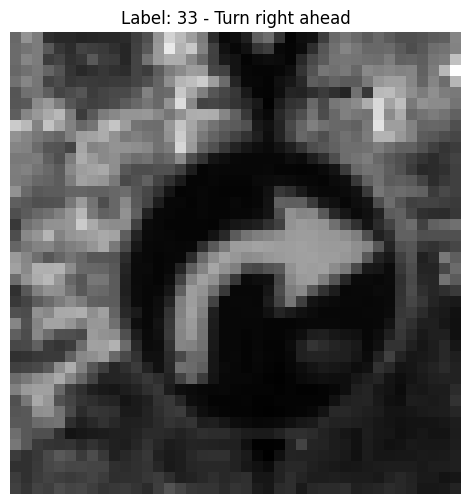

In [34]:
## Appying the function and the image was converted succesfully.

gray_img = grayscale(train_df['filepaths'].iloc[idx])
plt.figure(figsize=(6,6))
plt.imshow(gray_img,cmap='gray')
plt.title(f"Label: {label} - {title}")
plt.axis("off")
img_arr = np.array(gray_img)

# Printing additional info to check the channel and it has 1 depth now
print("Random index:", idx)
print("Image Shape", img_arr.shape)

Please note that one of the reasons why i converted my Images to Grayscale is because when distinguishing between traffic signs is that color is not necessarily the most significant feature. The most important characteristics are the edges, curves, shapes, and overall geometry of the sign, which are what the network primarily learns to recognize.

When we convert an image from RGB to grayscale, we reduce the depth of the image from 3 channels to 1. This means the network requires fewer parameters and less computing power to process and classify the data. This is another challenge i'm trying to migitate as i dont have much computing power

However, this conversion is optional. If you have sufficient computational resources, you can keep the RGB images without any issues.



In [35]:
## The second preprocessing step is the histogram equalization to add brightness to images

def equalize(img_path):
    img = cv2.equalizeHist(img_path)
    return img

Random index: 1
Image shape: (42, 41)


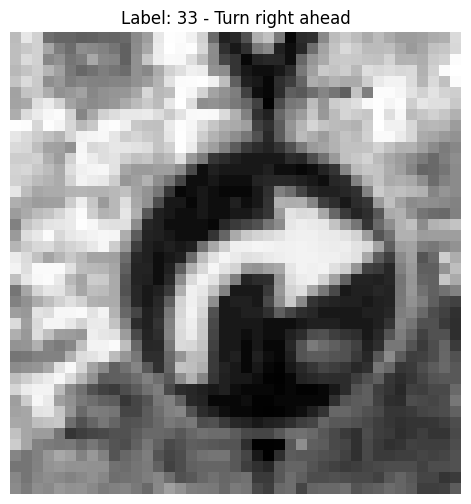

In [36]:

## Equalizing
histEqualize_img = equalize(gray_img)

## Display image
plt.figure(figsize=(6,6))
plt.imshow(histEqualize_img, cmap='gray')
plt.title(f"Label: {label} - {title}")
plt.axis("off")

print("Random index:", idx)
print("Image shape:", histEqualize_img.shape)

## Did you notice the increase in brightness? Oh yes, the preprocessing worked successfully.



From the visualization of the 43 classes above, we can see that many of the images are not bright enough. Therefore, I applied histogram equalization to standardize the lighting across all images.

A very important note: if you are working with  RGB images, performing histogram equalization  will be a bad practise, this is another vital reason i converted my Images to Grayscale. Please take note

In [38]:
## Placing all the preprocessing steps ina. function, also included resizing and scaling preprocessing steps

def preprocessing(img):
    img = grayscale(img)
    img = cv2.resize(img, (32, 32))
    img = equalize(img)
    img = img/255
    return img

In [39]:
## As I mentioned earlier, to load any image from the test_df, I need to prepend the root directory to the file paths.

test_df["filepaths"] = "/kaggle/input/gtsrb-german-traffic-sign/" + test_df["filepaths"]


In [41]:
# file path now in the corrected form

print(test_df['filepaths'].head())

0    /kaggle/input/gtsrb-german-traffic-sign/Test/0...
1    /kaggle/input/gtsrb-german-traffic-sign/Test/0...
2    /kaggle/input/gtsrb-german-traffic-sign/Test/0...
3    /kaggle/input/gtsrb-german-traffic-sign/Test/0...
4    /kaggle/input/gtsrb-german-traffic-sign/Test/0...
Name: filepaths, dtype: object


In [ ]:
## Applying the processing function and looping through all images in the train, valid, and test dataframe

processed_X_train = np.array(list(map(preprocessing, train_df['filepaths'])))
processed_X_val = np.array(list(map(preprocessing, val_df['filepaths'])))
processed_X_test = np.array(list(map(preprocessing, test_df['filepaths'])))

In [44]:
## Now, my images are consistent and ready for training and  evaluation

print(processed_X_train.shape)
print(processed_X_val.shape)
print(processed_X_test.shape)

(33327, 32, 32)
(5882, 32, 32)
(12630, 32, 32)


In [45]:
## Recall that my labels were stored as object types. I’m now converting them into one-hot encoded format using to_categorical.
## You can convert to integer depends on your workflow

y_train = to_categorical(train_df['labels'], num_classes=43)
y_val = to_categorical(val_df['labels'], num_classes=43)
y_test = to_categorical(test_df['labels'], num_classes=43)

In [46]:
## converted succesfully

y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

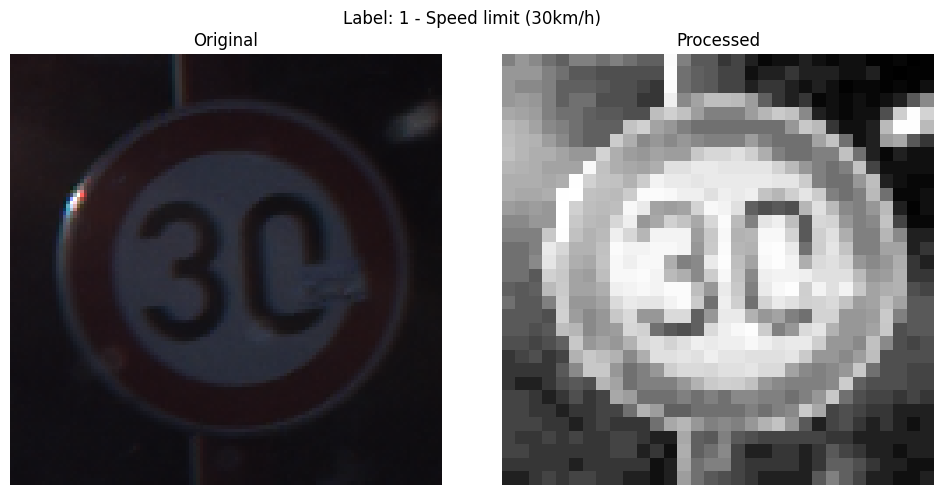

In [47]:
## Now, lets visualize original tran_df and processed train_df to ensure the preprocessing worked as expected

## Pick a random index
idx = random.randint(0, len(train_df) - 1)

## Loading the original image
orig_img = Image.open(train_df['filepaths'].iloc[idx])

## Loading the processed image
proc_img = processed_X_train[idx]


## Ploting side by side
plt.figure(figsize=(10,5))

## Original image
plt.subplot(1,2,1)
plt.imshow(orig_img)
plt.title("Original")
plt.axis("off")

## Processed image
plt.subplot(1,2,2)
plt.imshow(proc_img, cmap="gray")
plt.title("Processed")
plt.axis("off")

plt.suptitle(f"Label: {train_df['labels'].iloc[idx]} - {train_df['title'].iloc[idx]}")
plt.tight_layout()
plt.show()


The processing steps worked as expected, please note that the cnn expects 3 input that is 32,32,3 or 32,32,1 and currently the processed images are 32,32

In [47]:
# Please note: The network expects inputs with 3 dimensions (height, width, channels).
# Since my processed images are in grayscale, I need to reshape them to include a channel dimension.

processed_X_train = processed_X_train.reshape(33327,32, 32, 1)
processed_X_val = processed_X_val.reshape(5882,32, 32, 1)
processed_X_test = processed_X_test.reshape(12630,32, 32, 1)

## please note, this steps can be included at the  end of the preprocessing  function

In [48]:
print(processed_X_train.shape)
print(processed_X_val.shape)
print(processed_X_test.shape)

(33327, 32, 32, 1)
(5882, 32, 32, 1)
(12630, 32, 32, 1)


## model Development

In [69]:
## Buikding my network

def leNet_model():
  model = Sequential()
  model.add(Conv2D(30, (5,5), input_shape=(32,32,1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(15, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))

 # Compiling the model
  model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = leNet_model()

##  The architecture of my entire convolutional network
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 30)     │           780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 15)     │         4,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 15)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 540)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 500)            │       270,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,888 (1.13 MB)

 Trainable params: 296,888 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(processed_X_train, y_train, epochs=10, validation_data=(processed_X_val, y_val), batch_size=10, verbose=1, shuffle=1)

Epoch 1/10
3333/3333 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.5800 - loss: 1.5196 - val_accuracy: 0.9464 - val_loss: 0.1953
Epoch 2/10
3333/3333 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9262 - loss: 0.2306 - val_accuracy: 0.9694 - val_loss: 0.1150
Epoch 3/10
3333/3333 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9577 - loss: 0.1355 - val_accuracy: 0.9684 - val_loss: 0.1001
Epoch 4/10
3333/3333 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9678 - loss: 0.1047 - val_accuracy: 0.9764 - val_loss: 0.0822
Epoch 5/10
3333/3333 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9728 - loss: 0.0847 - val_accuracy: 0.9789 - val_loss: 0.0749
Epoch 6/10
3333/3333 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9759 - loss: 0.0741 - val_accuracy: 0.9820 - val_loss: 0.0618
Epoch 7/10
3333/3333 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9771 - loss: 0.0692 - val_accuracy: 0.9855 - val_loss: 0.0539
Epoch 8/10
3333/3333 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9803 - loss: 0.

Text(0.5, 0, 'epoch')

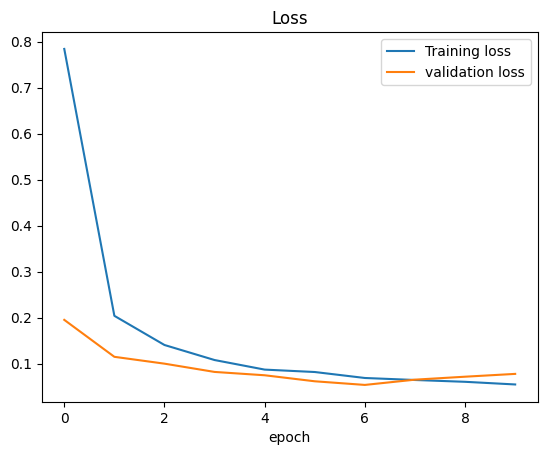

In [ ]:
## Plotting the loss of my network history

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training loss','validation loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

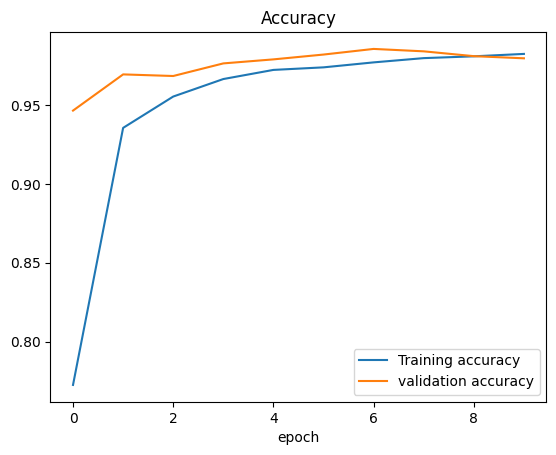

In [ ]:
## Plotting the Accuracy of my network history

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training accuracy','validation accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

## Final Evaluation with the test data

In [ ]:

predictions = model.predict(processed_X_test)

pred = (predictions > 0.5).astype(int)

## Printing the classification report -- optional
print(classification_report(y_test, pred))

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.77      0.84        60
           1       0.90      0.95      0.93       720
           2       0.96      0.98      0.97       750
           3       0.94      0.94      0.94       450
           4       0.98      0.93      0.96       660
           5       0.91      0.93      0.92       630
           6       0.98      0.79      0.88       150
           7       0.96      0.92      0.94       450
           8       0.96      0.87      0.91       450
           9       0.94      1.00      0.97       480
          10       1.00      0.97      0.98       660
          11       0.87      0.97      0.92       420
          12       0.99      0.97      0.98       690
          13       0.98      0.99      0.99       720
          14       1.00      0.98      0.99       270
          15       0.81      0.96      0.88       210
          16       1.00      0.99      1

In [ ]:
## Test loss and accuracy

score = model.evaluate(processed_X_test, y_test)

print('Test loss: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9396 - loss: 0.3166
Test loss: 0.3276597261428833
Test Accuracy: 0.9382422566413879


**🔍 Training and Validation Performance**

Training accuracy reached 98% by epoch 10.

Validation accuracy peaked around 98.5%.

Validation loss was lowest around epoch 7 (~0.05) and then rose slightly to ~0.07–0.08 in later epochs.

This mild increase in validation loss while accuracy remained high is a sign of slight overfitting, the model is performing excellently but not what i expected.

**🎯 Test Performance**

Test accuracy: ~94%

Test loss: ~0.32

This is a small drop compared to the validation performance (from ~98% → ~94%):

The test set is likely harder or less similar to the training data.

Some variability is normal when generalizing to unseen examples.


While the results are strong, I would love to improve this model further, as I am very meticulous and want it to be as accurate as possible in predicting all classes.

I will introduce Early Stopping, since there was a noticeable uptick in validation loss around epoch 10, to prevent overfitting.

I will also apply Data Augmentation techniques so the model can train on more diverse images, improving its generalization to new data.

I might also improve more dropout and convolution layers.



That said, let me test this method first before i improve it.

## Testing my model with random images

In [ ]:
img_path = "/content/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg"


Image Shape: (956, 1300, 3)


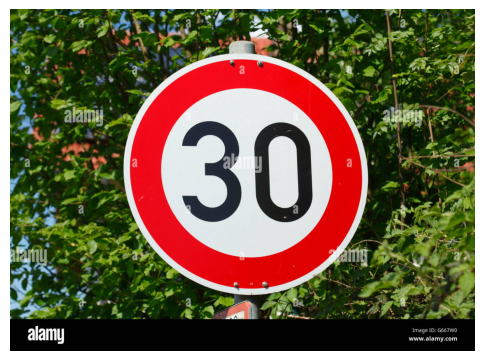

In [ ]:
pic = Image.open(img_path)
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
img_array = np.array(img)
# 5. Print additional info
print("Image Shape:", img_array.shape)
plt.show()

## This image belongs to class 1

In [ ]:

# 2. Preprocess
img_processed = preprocessing(img_path)

(32, 32)


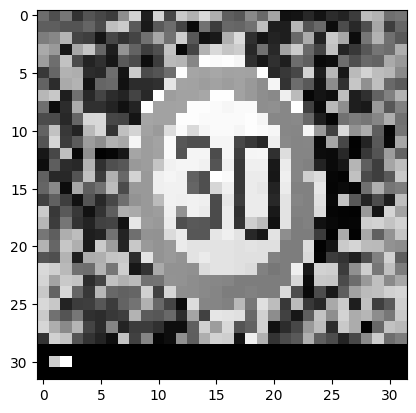

In [ ]:
plt.imshow(img_processed,cmap='gray')
print(img_processed.shape)

In [ ]:
img_processed = img_processed.reshape(1,32,32,1)

In [ ]:
print("predicted sign: " + str(np.argmax(model.predict(img_processed))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
predicted sign: 1


In [ ]:
## IMAGE 2

img_path = "/content/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg"


Image Shape: (956, 1300, 3)


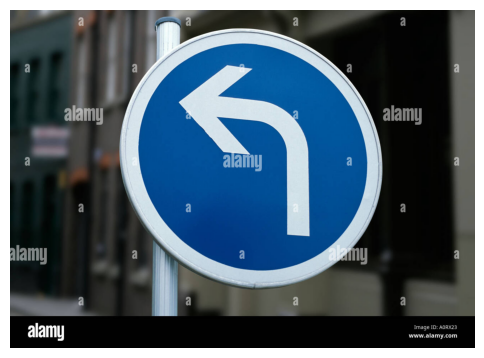

In [ ]:


pic = Image.open(img_path)
plt.figure(figsize=(6,6))
plt.imshow(pic)
plt.axis("off")
img_array = np.array(img)
# 5. Print additional info
print("Image Shape:", img_array.shape)
plt.show()

## This image belongs to class 34

(32, 32)


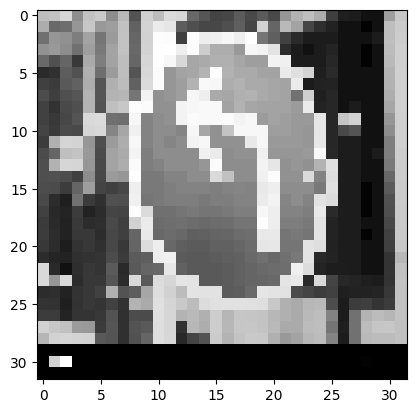

In [ ]:
img_processed = preprocessing(img_path)
plt.imshow(img_processed,cmap='gray')
print(img_processed.shape)

In [ ]:
img_processed = img_processed.reshape(1,32,32,1)

In [ ]:
print("predicted sign: " + str(np.argmax(model.predict(img_processed))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
predicted sign: 11


Image Shape: (956, 1300, 3)


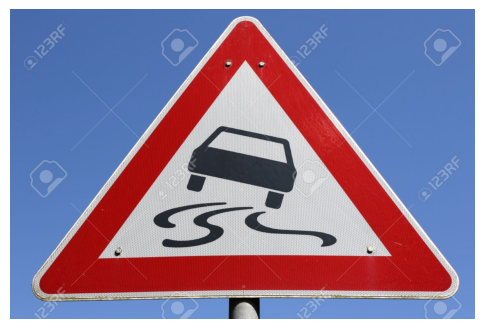

In [ ]:
## IMAGE 3

img_path = "/content/64914157-german-road-sign-slippery-road.jpg"
pic = Image.open(img_path)
plt.figure(figsize=(6,6))
plt.imshow(pic)
plt.axis("off")
img_array = np.array(img)
# 5. Print additional info
print("Image Shape:", img_array.shape)
plt.show()

## This image belongs to class 23

(32, 32)


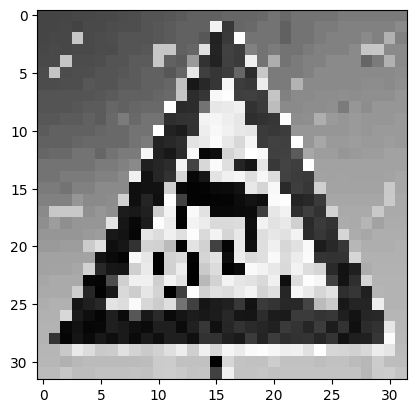

In [ ]:
img_processed = preprocessing(img_path)
plt.imshow(img_processed,cmap='gray')
print(img_processed.shape)

In [ ]:
img_processed = img_processed.reshape(1,32,32,1)

In [ ]:
print("predicted sign: " + str(np.argmax(model.predict(img_processed))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
predicted sign: 23


Image Shape: (956, 1300, 3)


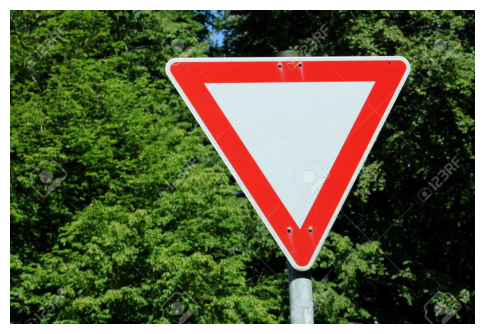

In [ ]:
## IMAGE 4

img_path = "/content/5155701-german-traffic-sign-no-205-give-way.jpg"
pic = Image.open(img_path)
plt.figure(figsize=(6,6))
plt.imshow(pic)
plt.axis("off")
img_array = np.array(img)
# 5. Print additional info
print("Image Shape:", img_array.shape)
plt.show()

## This image belongs to class 13

(32, 32)


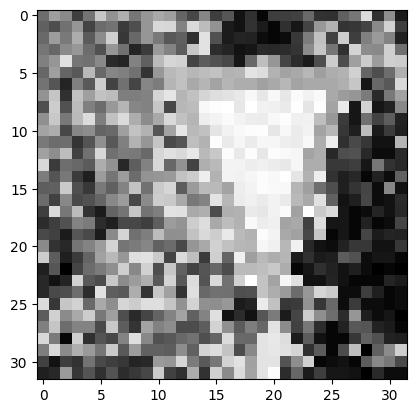

In [ ]:
img_processed = preprocessing(img_path)
plt.imshow(img_processed,cmap='gray')
print(img_processed.shape)

In [ ]:
img_processed = img_processed.reshape(1,32,32,1)

In [ ]:
print("predicted sign: " + str(np.argmax(model.predict(img_processed))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
predicted sign: 13


Image Shape: (42, 41, 3)


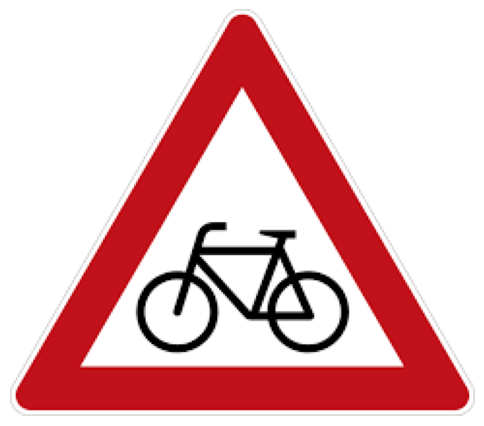

In [107]:
## IMAGE 5

img_path = "/content/images.png"
pic = Image.open(img_path)
plt.figure(figsize=(6,6))
plt.imshow(pic)
plt.axis("off")
img_array = np.array(img)
# 5. Print additional info
print("Image Shape:", img_array.shape)
plt.show()

## This image belongs to class 29

(32, 32)


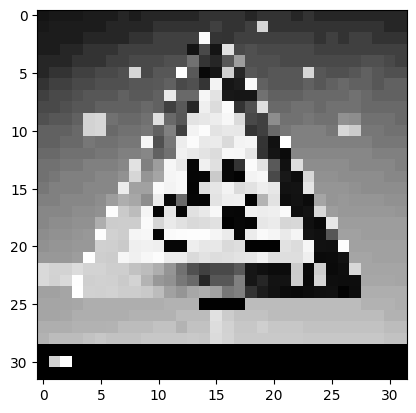

In [ ]:
img_processed = preprocessing(img_path)
plt.imshow(img_processed,cmap='gray')
print(img_processed.shape)

In [ ]:
img_processed = img_processed.reshape(1,32,32,1)

In [ ]:
print("predicted sign: " + str(np.argmax(model.predict(img_processed))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
predicted sign: 30


In my testing above, the model correctly predicted 3 signs and misclassified 2 signs. This indicates that the model is not yet robust, as such misclassifications could cause serious problems in a self-driving car scenario. I will need to further fine-tune and improve the model to enhance its accuracy and reliability.

## FINE-TUNING THE MODEL

In [49]:
## please note that i will be using my preprocessed x_ train and as such i dont need to scale anymore

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1
)
datagen.fit(processed_X_train)

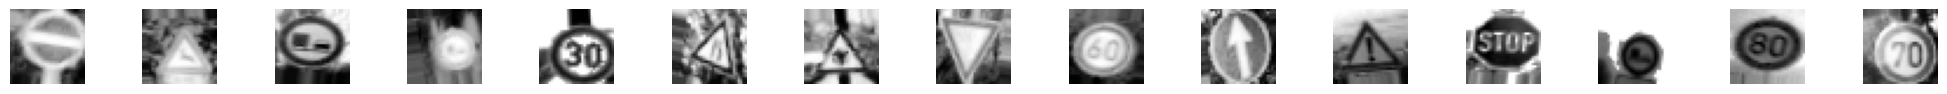

In [50]:
## Using the next function and storing the new images into X_baches and y_batches

batches = datagen.flow(processed_X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)


fig, axs = plt.subplots(1,15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32), cmap='gray')
  axs[i].axis('off')

plt.show()

Wow, the ImageDataGenerator is working perfectly. As we can see, it’s generating new, augmented images as intended.

In [93]:
## Rebuilding the achitecture

def leNet_model():
  model = Sequential()
  model.add(Conv2D(100, (5,5), input_shape=(32,32,1), activation='relu'))
  model.add(Conv2D(100, (5,5),  activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))



  model.add(Conv2D(30, (3,3), activation='relu'))
  model.add(Conv2D(30, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))

 # Compiling the model
  model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [94]:
model = leNet_model()


In [95]:
history = model.fit(datagen.flow(processed_X_train, y_train,batch_size=30), epochs=10, validation_data=(processed_X_val, y_val), steps_per_epoch=2000, shuffle=1)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.4522 - loss: 1.9677 - val_accuracy: 0.9269 - val_loss: 0.2560
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8419 - loss: 0.5080 - val_accuracy: 0.9743 - val_loss: 0.0875
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9037 - loss: 0.3034 - val_accuracy: 0.9867 - val_loss: 0.0522
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9245 - loss: 0.2419 - val_accuracy: 0.9888 - val_loss: 0.0393
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9407 - loss: 0.1906 - val_accuracy: 0.9816 - val_loss: 0.0516
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9431 - loss: 0.1793 - val_accuracy: 0.9905 - val_loss: 0.0346
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9516 - loss: 0.1550 - val_accuracy: 0.9929 - val_loss: 0.0283
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9560 - loss: 

Text(0.5, 0, 'epoch')

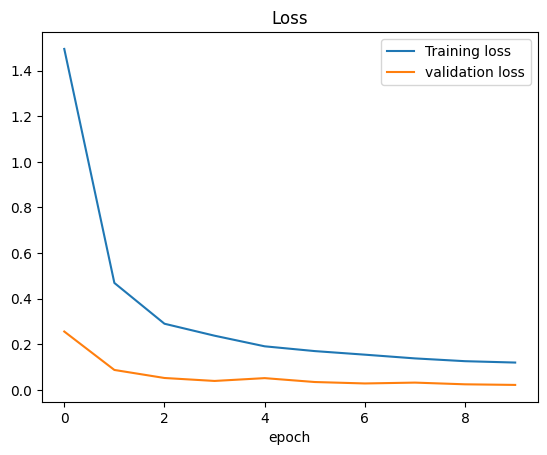

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training loss','validation loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

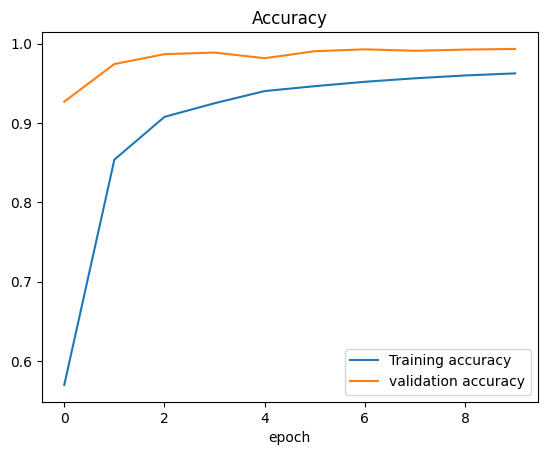

In [108]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training accuracy','validation accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

## Final Evaluation

In [102]:
score = model.evaluate(processed_X_test, y_test)

print('Test loss: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9654 - loss: 0.1334
Test loss: 0.13241419196128845
Test Accuracy: 0.964845597743988


✅ After tuning for many hours with extensive trial and error, I achieved excellent results:

Final Test Accuracy: ~96.5%

Final Test Loss: ~0.13

The model shows strong generalization and consistent improvement across training, validation, and test sets

Now, let evaluate the random images again

## Model Testing

Image Shape: (42, 41, 3)


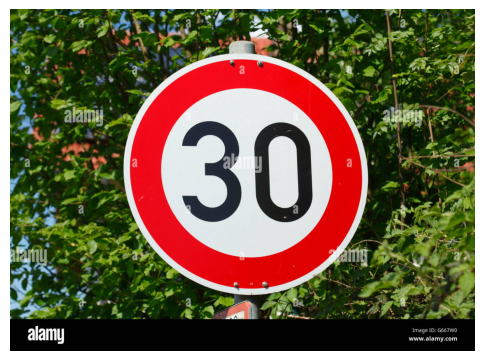

In [142]:
img_path = "/content/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg"
pic = Image.open(img_path)
plt.figure(figsize=(6,6))
plt.imshow(pic)
plt.axis("off")
img_array = np.array(img)
# Print additional info
print("Image Shape:", img_array.shape)
plt.show()

## This image belongs to class 1

(32, 32)


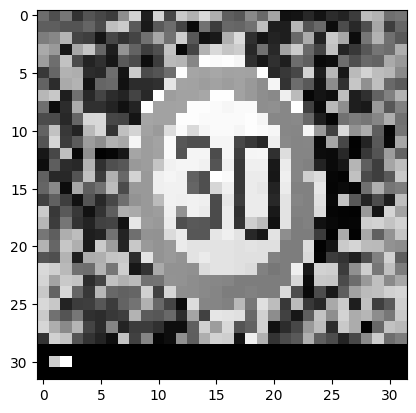

In [143]:
img_processed = preprocessing(img_path)
plt.imshow(img_processed,cmap='gray')
print(img_processed.shape)

In [144]:
img_processed = img_processed.reshape(1,32,32,1)

In [145]:
print("predicted sign: " + str(np.argmax(model.predict(img_processed))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
predicted sign: 1


Image Shape: (42, 41, 3)


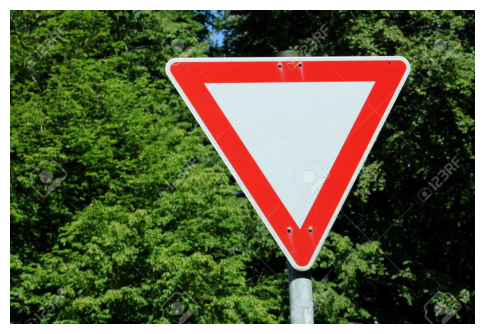

In [146]:
img_path = "/content/5155701-german-traffic-sign-no-205-give-way.jpg"
pic = Image.open(img_path)
plt.figure(figsize=(6,6))
plt.imshow(pic)
plt.axis("off")
img_array = np.array(img)
# 5. Print additional info
print("Image Shape:", img_array.shape)
plt.show()

## This image belongs to class 13

(32, 32)


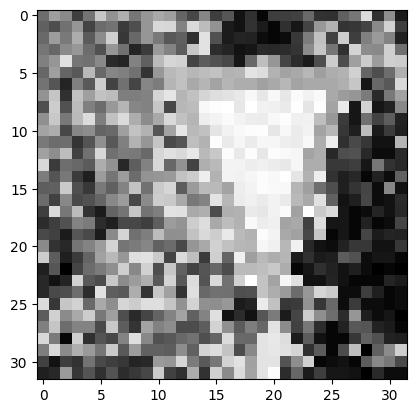

In [147]:
img_processed = preprocessing(img_path)
plt.imshow(img_processed,cmap='gray')
print(img_processed.shape)

In [148]:
img_processed = img_processed.reshape(1,32,32,1)

In [149]:
print("predicted sign: " + str(np.argmax(model.predict(img_processed))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
predicted sign: 13


Image Shape: (42, 41, 3)


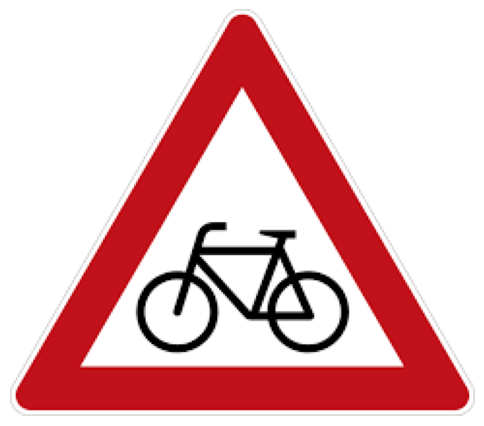

In [103]:
img_path = "/content/images.png"
pic = Image.open(img_path)
plt.figure(figsize=(6,6))
plt.imshow(pic)
plt.axis("off")
img_array = np.array(img)

# Print additional info
print("Image Shape:", img_array.shape)
plt.show()

## This image belongs to class 29

(32, 32)


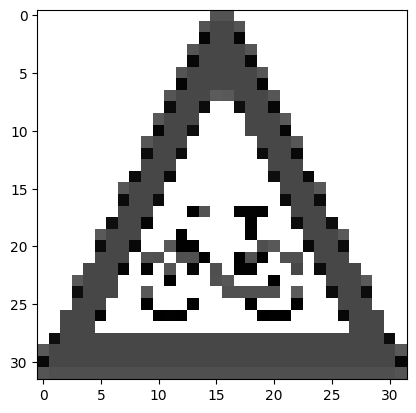

In [104]:
img_processed = preprocessing(img_path)
plt.imshow(img_processed,cmap='gray')
print(img_processed.shape)

In [105]:
img_processed = img_processed.reshape(1,32,32,1)

In [106]:
print("predicted sign: " + str(np.argmax(model.predict(img_processed))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
predicted sign: 29


After performing extensive fine-tuning and improvements, the model was able to classify all test signs correctly, significantly enhancing its accuracy and reliability.

In [118]:
## Saving the model for production

model.save('my_traffic_model.keras')

 The end of the project. Thank you for following along. I have saved the model and will be uploading it to my GitHub repository if you’d like to try it out. Please feel free to reach out if you have any questions.

I am also open to new remote opportunities in data science and machine learning. Thank you!

## MY Portfolio: https://www.datascienceportfol.io/Patrick090

## LINKEDLIN: https://www.linkedin.com/in/patrickedosoma/